In [ ]:
import example
import cs.cs as space
example.generate('Swan')
print(space._concepts['birdfromSwan'])

In [7]:
a=[1,2,3]
a.append([4,5,6])
print(a)

[1, 2, 3, [4, 5, 6]]


In [11]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.core import from_cuboids
from cs.concept import Concept
import matplotlib.pyplot as plt
import visualization.concept_inspector as ci
import numpy as np
from matplotlib import patches
from sklearn.metrics import average_precision_score
from functools import reduce

#Get data from path to xml and add to given data
def xml_to_dict(path, data = {}, domain_mapping={}, dimension_names=[]):
    tree = ET.parse(os.path.normpath(path))
    root = tree.getroot()
    newdata={}
    for exemplar in root:
        new_concept = get_domains(exemplar)
        if(new_concept):
            newdata[exemplar.attrib['name']] = new_concept
    
    #list potentially new domains
    domains={}
    for exemplar in newdata.values():
        domains.update(exemplar)
    del(domains['supercategory'])
    
    #domains = mapping: domain->dimension indices, also add new dimension names
    if domain_mapping:
        i=sum([len(domain) for domain in domain_mapping.values()])
    else:
        i=0
    for key in domains:
        if not key in domain_mapping:
            for dim in domains[key]:
                dimension_names+=[dim]
            domain_mapping[key]=list(range(i,i+len(domains[key])))
            i+=len(domains[key])
    
    #kick inconsistents
    to_del=[]
    for datum in newdata:
        if not is_consistent(newdata[datum], domain_mapping):
            to_del+=[datum]
    for kickit in to_del:
        del(newdata[kickit])
    
    #translate to point
    for datum in newdata:
        point=[]
        for domain in domain_mapping:
            if domain in newdata[datum]:
                point+=list(newdata[datum][domain].values())
            else:
                point+=[float('inf')]*len(domain_mapping[domain])     
        newdata[datum]={'supercategory':newdata[datum]['supercategory'], 'point':point}
    data.update(newdata)
    return domain_mapping, data, dimension_names

def family_into_space(name, values):
    cuboids=[]
    domains = {}
    for point in values:
        subdomains=point_to_domains(point)
        cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
        domains.update(subdomains)
    core=from_cuboids(cuboids,domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    space.add_concept(name,concept)

    
#Group data by their supercategories to form concepts
def form_supercategories(data):
    concepts={}
    for datum in data.values():
        if datum['supercategory'] in concepts:
            concepts[datum['supercategory']].append(datum['point'])
        else:
            concepts[datum['supercategory']]=[datum['point']]
        #del(concepts[datum['supercategory']])
    return concepts
    
#helper for xml_to_dict, important for how the data is supposed to look like
def get_domains(xml_elem):
    domains = xml_elem.find('genericPhysicalDescription')
    if(not(domains)):
        return
    domain_dict={}
    try:
        supercategory = xml_elem.find('family').text
        if supercategory in ['feline','rodent','primate','cetacean']:
            supercategory='mammal'
        elif supercategory in ['crustacean']:
            supercategory = 'arthropod'
        elif supercategory in ['fruit', 'transport', 'furniture', 'book', 'building', 'musical_instrument', 'present', 'architectural_element']:
            supercategory = 'object'
        domain_dict['supercategory']=supercategory
    except AttributeError:
        domain_dict['supercategory']="object"
        
    for domain in domains:
        numerical_domain={}
        for subelem in domain:
            try:
                numerical_domain[subelem.tag]=float(subelem.text)
            except ValueError:
                pass
        if numerical_domain:
            domain_name=domain.tag
            
            if not (domain_name=='size' or domain_name=='location'):
                pass
            elif(domain_name=='hasPart' or domain_name=='partOf'):
                pass
                '''domain_name = domain.get('name')
                domain_dict['n_'+domain_name]={'number_'+domain_name:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}'''
            else:
                domain_dict[domain_name]={key:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}
    return domain_dict

def domains_from_point(point):
    domains={}
    for domain in space._domains:
        if all(not point[dim]==float('inf') for dim in space._domains[domain]):
            domains[domain]=space._domains[domain]
    return domains

def point_to_concept(point, name):
    domains = domains_from_point(point)
    p_min=[value if not value==float('inf') else float('-inf') for value in point]
    c_example = Cuboid(p_min, point, domains)
    s_example = Core([c_example], domains)
    w_example = Weights(space._def_dom_weights,space._def_dim_weights)
    concept = Concept(s_example, 1.0, C, w_example)
    space.add_concept(name, concept)
    return concept

#We do not want any concepts with partially filled domains. This would go against the very idea of domains. input: {doms:values}. Also concepts with only undefined dims are not needed
def is_consistent(concept, domain_mapping={}):
    inf_check=[]
    if not domain_mapping:
        domain_mapping=space._domains
    for domain in concept:
        if not domain=='supercategory':
            if not(len(concept[domain])==len(domain_mapping[domain])):
                return False
            inf_check+=concept[domain]
    if all([check==float('inf') for check in inf_check]):
        return False
    return True

#Normalize given instance of data, return respective z-transformation, needs initialized space
def normalize_data(data, domain_mapping={}):
    if not domain_mapping:
        domain_mapping=space._domains
        n_dim=space._n_dim
    else:
        n_dim=sum([len(dims) for dims in domain_mapping.values()])
        
    maxval=[float('-inf') for _ in range(n_dim)]
    minval=[float('inf') for _ in range(n_dim)]
    for datum in data.values():
        maxval=[max([maxval[i], datum['point'][i] if not datum['point'][i]==float('inf') else maxval[i]]) for i in range(n_dim)]
        minval=[min([minval[i], datum['point'][i] if not datum['point'][i]==float('-inf') else minval[i]]) for i in range(n_dim)]
    middle=[(maxval[i]+minval[i])/2 for i in range(n_dim)]
    halfrange=[maxval[i]-middle[i] for i in range(n_dim)]
    norm=lambda x: [(x[i]-middle[i])/halfrange[i] for i in range(n_dim)]
    
    for datum in data.values():
        datum['point']=list(norm(datum['point']))
        
    if space:
        space._norm=norm
    return norm

    

def get_names(domains):
    dimension_names = []
    for domain in domains.values():
        dimension_names += [dim for dim in domain.keys()]
        
def dict_to_point(concept_dict):
    point=[concept_dict.get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
    #flatten
    point= [p for dom in point for p in dom]
    return point

def point_to_domains(point):
    domains={}
    for dim in range(space._n_dim):
        if not(point[dim]==float('inf') or point[dim]==float('-inf')):
            domains[space.dim_to_dom[str(dim)]]=space._domains[space.dim_to_dom[str(dim)]]
    return domains

def one_shot(point, method=None, sibblings=None, name="newlearned"):
    return method(point, sibblings)

def two_cubs_PCA(point, sibblings):
    n_dims=len(point)
    if sibblings==None:
        sibblings=get_sibblings(supercategory)
    
    variances=[]
    pcs=[]
    correlations=[]
    stds=[]#np.std(centers)
    avg = np.average#lambda values: sum(values)/len(values)
    for sibbling in sibblings:
        centers = np.array([[p_max-p_min for p_max,p_min in zip(cuboid._p_max, cuboid._p_min)] for cuboid in space._concepts[sibbling]._core._cuboids]).T
        #print(centers) good
        means=[]
        for dimension in range(len(centers)):
            means.append(avg([value for value in centers[dimension] if not value==float('inf')]))
            for value in range(len(centers[dimension])):
                if centers[dimension,value]==float('inf'):
                    centers[dimension,value]=means[-1]
        if(len(centers.T)==1):
            centers=np.array([[x[0],x[0]] for x in centers])
        stds.append(np.std(centers,1))
        covmat = np.cov(centers)
        corr=np.corrcoef(centers)
        #plt.scatter(centers[0],centers[1])
        variances.append(covmat)
        values, vectors = np.linalg.eig(covmat)
        '''print(values)
        print(vectors)
        print(vectors[np.argmax(values)]*max(values))'''
        pcs.append(vectors[np.argmax(values)]*max(values))
    meanpc=sum(pcs)/len(pcs)
    '''print('pcs\n',pcs)
    print('meanpc\n',meanpc)'''
    cub1=np.zeros(n_dims)
    cub2=np.zeros(n_dims)
    
    for dim in range(n_dims):
        cub1[dim]=point[dim]-meanpc[dim]
        cub2[dim]=point[dim]+meanpc[dim]

    c1_p_min=[2*cub1[dim]-point[dim] if cub1[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c1_p_max=[2*cub1[dim]-point[dim] if cub1[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    c2_p_min=[2*cub2[dim]-point[dim] if cub2[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c2_p_max=[2*cub2[dim]-point[dim] if cub2[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    domains = domains_from_point(c1_p_max)
    core=Core([Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains)],domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    '''print(Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains))
    print(concept)'''
    return concept
    
def two_cuboids(point, sibblings):
    #fig,ax = plt.subplots(1)
    
    n_dims=len(point)
    if sibblings==None:
        sibblings=get_sibblings(supercategory)
    
    #print(point,'\n',sibblings)
    variances=[]
    correlations=[]
    stds=[]#np.std(centers)
    avg = np.average#lambda values: sum(values)/len(values)
    for sibbling in sibblings:
        centers = np.array([[p_max-p_min for p_max,p_min in zip(cuboid._p_max, cuboid._p_min)] for cuboid in space._concepts[sibbling]._core._cuboids]).T
        #print(centers) good
        means=[]
        for dimension in range(len(centers)):
            means.append(avg([value for value in centers[dimension] if not value==float('inf')]))
            for value in range(len(centers[dimension])):
                if centers[dimension,value]==float('inf'):
                    centers[dimension,value]=means[-1]
        if(len(centers.T)==1):
            centers=np.array([[x[0],x[0]] for x in centers])
        #print('centers\n',centers)
        stds.append(np.std(centers,1))
        #covmat = np.cov(centers)
        corr=np.corrcoef(centers)
        print('corr\n',corr)
        #plt.scatter(centers[0],centers[1])
        #variances.append(covmat)
        if not np.isnan(corr[0,0]):
            correlations.append(corr)
    meanstds=np.zeros(n_dims)
    meancorrelations=np.zeros([n_dims, n_dims])
    for i in range(n_dims):
        meanstds[i] = avg([stds[sib][i] for sib in range(len(stds))])
        #meanvariances[i] = avg([(variance_of_sibbling[i,i])**(1/2) for variance_of_sibbling in variances])
        for j in range(n_dims):
            meancorrelations[i,j]= avg([correlations_of_sibbling[i,j] for correlations_of_sibbling in correlations])
    #print('meancorr\n',meancorrelations)
    #print(meanvariances)
    #print(meanstds)
    #print([avg([stds[sib][dim] for sib in range(len(stds))]) for dim in range(n_dims)])
    #print(meancorrelations)
    maindim=0
    cub1=np.zeros(n_dims)
    cub2=np.zeros(n_dims)
    cub1[maindim]=point[maindim]-meanstds[maindim]
    cub2[maindim]=point[maindim]+meanstds[maindim]
    
    for dim in range(n_dims):
        if not dim==maindim:
            cub1[dim]=point[dim]-meancorrelations[maindim,dim]*meanstds[maindim]
            cub2[dim]=point[dim]+meancorrelations[maindim,dim]*meanstds[maindim]
    '''print(cub1)
    print(cub2)'''
    c1_p_min=[2*cub1[dim]-point[dim] if cub1[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c1_p_max=[2*cub1[dim]-point[dim] if cub1[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    c2_p_min=[2*cub2[dim]-point[dim] if cub2[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c2_p_max=[2*cub2[dim]-point[dim] if cub2[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    domains = domains_from_point(c1_p_max)
    core=Core([Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains)],domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    '''print(Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains))
    print(concept)'''
    return concept


def verbose_example(example, data, concepts, domain_mapping, dim_names):
    showdim=4
    aps= evaluate_example(example, data, concepts, domain_mapping, dim_names, figure='developement', method=two_cubs_PCA)
    target=data[example]['supercategory']
    learnt=space._concepts[target+'from'+example]
    trainset={concept:concepts[concept] for concept in concepts if not concept==target}
    negatives=[point for family in trainset.values() for point in family]
    testset=list(concepts[target])
    testset.remove(data[example]['point'])
    print('AP learnt:',aps[example][0])
    print('AP naive:',aps[example][1])
    print(learnt)
    for dim in range(0,space._n_dim):
        if not dim == showdim:
            plt.figure(figsize=(15,15))

            ax=plt.gca()
            cub1=learnt._core._cuboids[0]
            cub2=learnt._core._cuboids[1]
            plt.scatter([point[showdim] for point in negatives],[point[dim] for point in negatives], color='r')
            plt.scatter([point[showdim] for point in testset],[point[dim] for point in testset], color='g', marker='.')
            rect = plt.Rectangle((cub1._p_min[showdim],cub1._p_min[dim]),cub1._p_max[showdim]-cub1._p_min[showdim],cub1._p_max[dim]-cub1._p_min[dim],fill=False)
            ax.add_patch(rect)
            rect = plt.Rectangle((cub2._p_min[showdim],cub2._p_min[dim]),cub2._p_max[showdim]-cub2._p_min[showdim],cub2._p_max[dim]-cub2._p_min[dim],fill=False)
            ax.add_patch(rect)
            plt.xlabel(str(showdim))
            plt.ylabel(str(dim))
            plt.show()
    
    
def evaluate_example(example, data, concepts, domains, dim_names, figure=None, method=two_cuboids):
    space.init(len(dim_names), domain_mapping,dim_names)
    target=data[example]['supercategory']

    trainset={concept:concepts[concept] for concept in concepts if not concept==target}
    testset=list(concepts[target])
    testset.remove(data[example]['point'])
    
    for family in trainset:
        family_into_space(family, trainset[family])
    
    sibblings = [concept for concept in space._concepts if not concept==target]
    learnt_category=one_shot(data[example]['point'], method,sibblings=sibblings,name=target+'from'+example)
    target_dict={}
    family_into_space(target, testset)
    naive_category=point_to_concept(data[example]['point'],'naive')
    negatives=[point for family in trainset.values() for point in family]
    positives=testset
    ap_naive=average_precision(naive_category, negatives.copy(), positives.copy(), figure=figure)
    ap_learnt=average_precision(learnt_category, negatives, positives, figure=figure, color='g')
    space.add_concept(target+'from'+example,learnt_category)
    return {example:[ap_learnt, ap_naive]}

def average_precision(concept, negatives, positives, threshold=0.5, color='r', figure=None):
    """Average Precision of the concept as a classifier

    Parameters:
    negatives (list): list of points that do not belong to the target class
    positives (list):...

    Returns:
    ap (float)

   """
    y_true=np.concatenate((np.ones(len(positives)),np.zeros(len(negatives))))
    y_scores=np.zeros(len(y_true))
    for i in range(len(y_scores)):
        if i < len(positives):
            y_scores[i]=concept.membership_of(positives[i])
        else:
            y_scores[i]=concept.membership_of(negatives[i-len(positives)])
    sorted_truths=[x for _,x in sorted(zip(y_scores,y_true),reverse=True)]
    recalls=[sum(sorted_truths[:i+1])/(sum(sorted_truths[:i+1])+sum(sorted_truths[i:])) for i in range(len(y_true))]
    precisions=[sum(sorted_truths[:i+1])/(i+1) for i in range(len(y_true))]
    '''print(sorted_truths)
    print(recalls)
    print(precisions)'''
    #plt.subplots(figsize=(10, 10))
    if figure=='part':
        plt.scatter(recalls, precisions, color = color)#[(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
    elif figure=='developement':
        plt.scatter(recalls, precisions, color = [(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    #plt.figure(figsize=(10,20))
    #plt.show()
    return average_precision_score(y_true, y_scores)

''

''

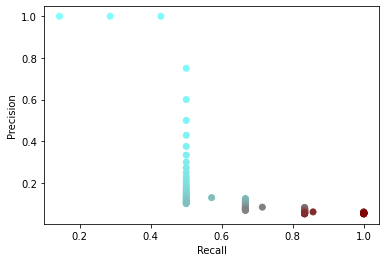

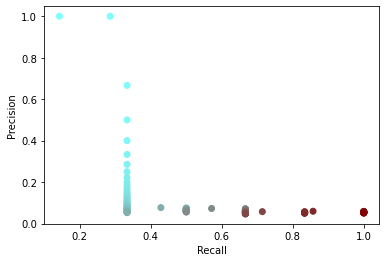

AP learnt: 0.26610772032259405
AP naive: 0.545495275333985
core: {[-inf, -inf, -inf, -inf, -1.1637015936446309, -1.0973892463863213, -0.9833994466482215]-[inf, inf, inf, inf, -0.998159852788223, -0.9959979989994997, -0.9833268537086158], [-inf, -inf, -inf, -inf, -0.998159852788223, -0.9959979989994997, -0.9834720395878273]-[inf, inf, inf, inf, -0.832618111931815, -0.8946067516126782, -0.9833994466482215]}
mu: 1.0
c: 0.05
weights: <{'location': 1.0, 'size': 1.0},{'location': {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 'size': {4: 0.3333333333333333, 5: 0.3333333333333333, 6: 0.3333333333333333}}>


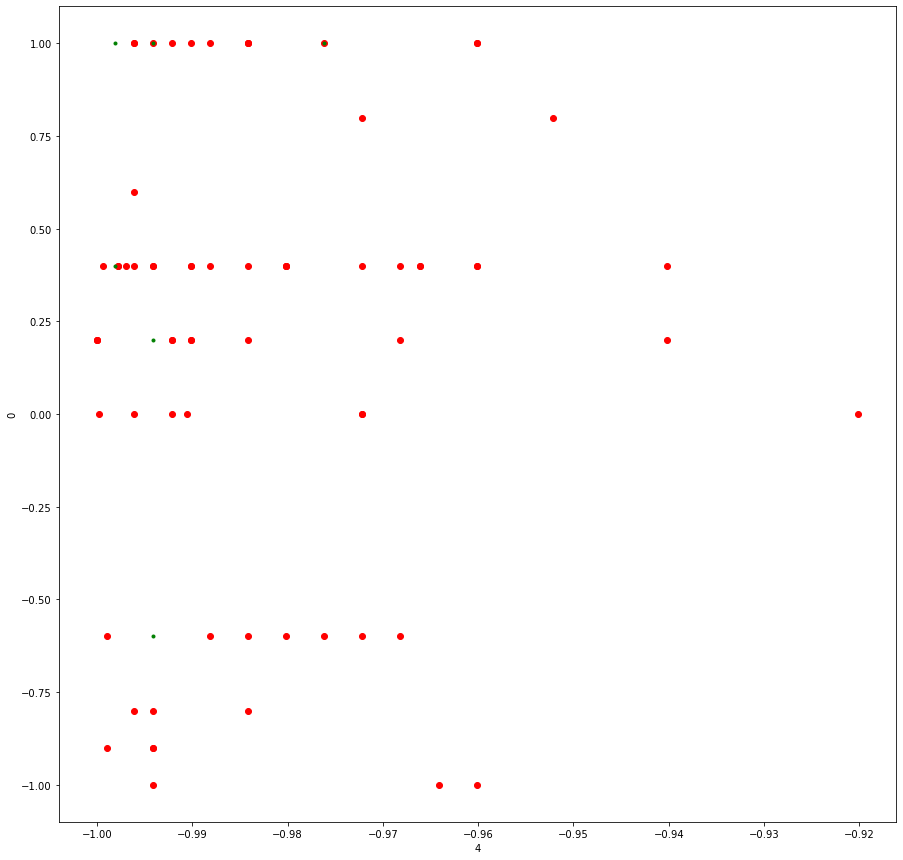

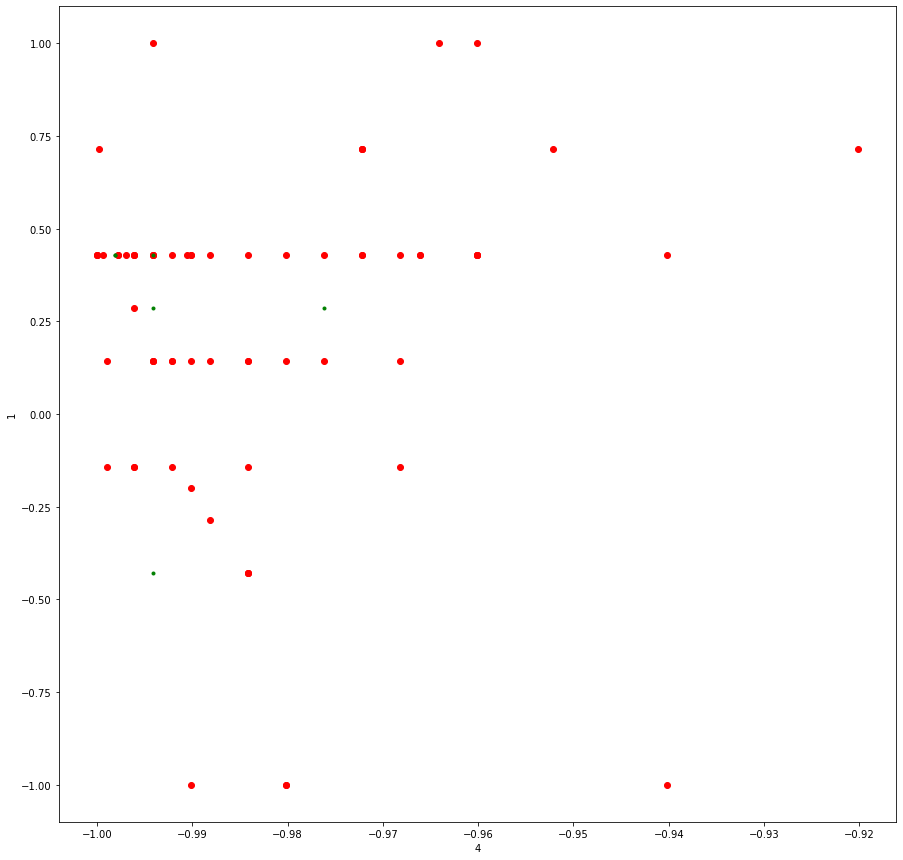

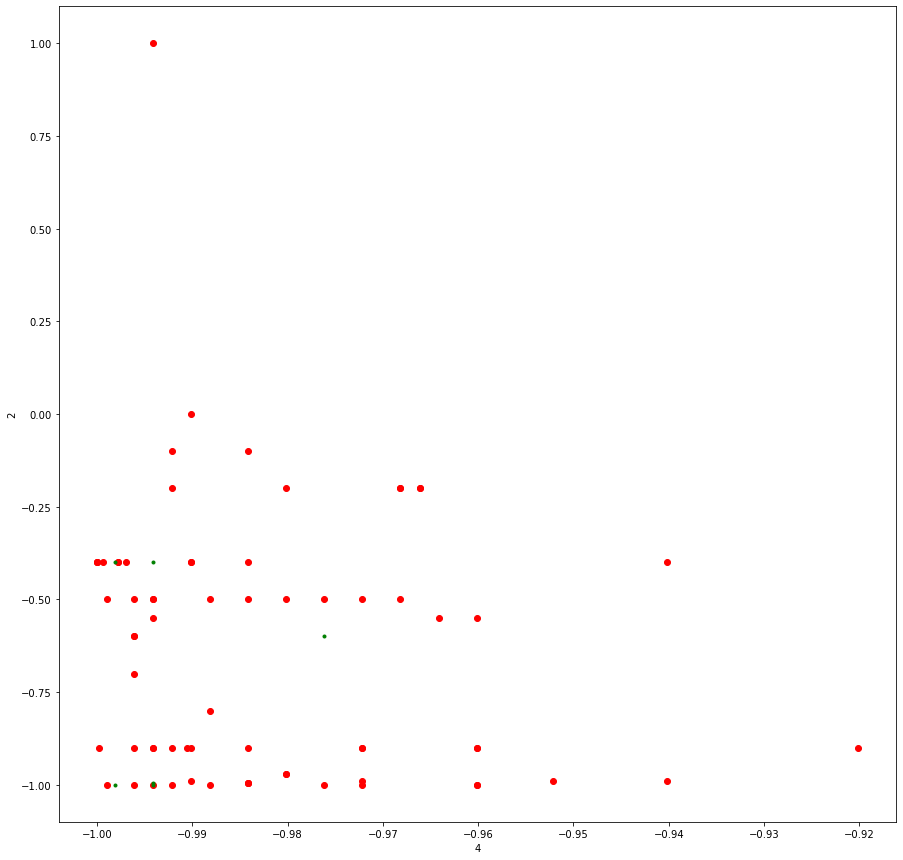

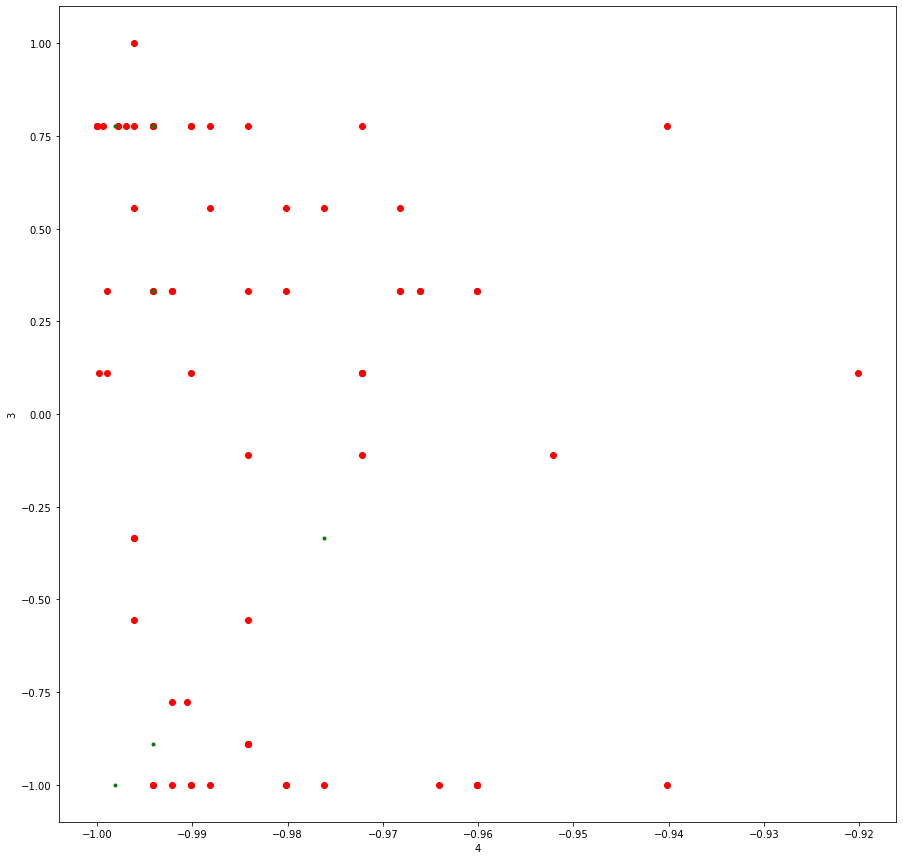

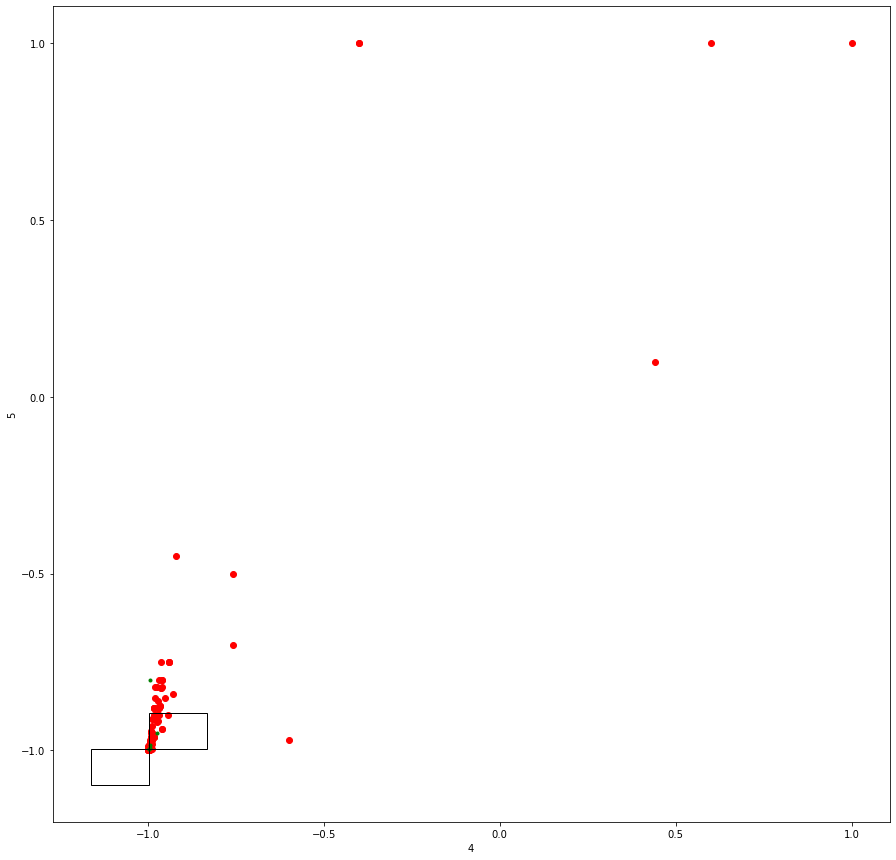

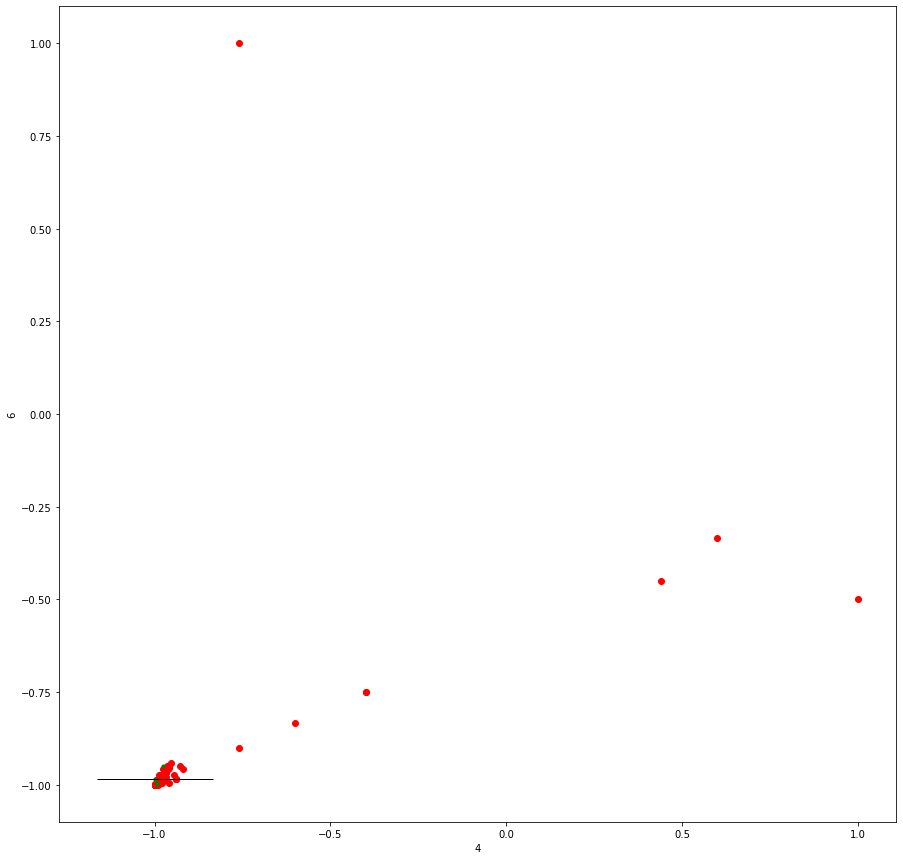

In [12]:
import warnings
warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

norm=normalize_data(data, domain_mapping)
concepts=form_supercategories(data)

verbose_example('coral_snake', data, concepts, domain_mapping, dim_names)

In [4]:
import warnings
warnings.filterwarnings("ignore")
C=0.05
#read concepts from prototypes and exemplars
domain_mapping, data, dim_names = xml_to_dict("Dataset\\prototypes.xml")
domain_mapping, data, dim_names = xml_to_dict("Dataset\\exemplars.xml", domain_mapping=domain_mapping, data=data, dimension_names=dim_names)

norm=normalize_data(data, domain_mapping)
concepts=form_supercategories(data)

aps={}
for example in data:
    if len(concepts[data[example]['supercategory']])-1:
        aps.update(evaluate_example(example, data, concepts, domain_mapping, dim_names, method=two_cubs_PCA))
    
ap=[x[0] for x in aps]
diff_ap=[x[0]-x[1] for x in aps.values()]
print(max(diff_ap))
print(min(diff_ap))
print(sum(diff_ap)/len(diff_ap))
print(aps[argmax(diff_ap)])

0.09211024662281353
-0.27938755501139095
-0.0230400824740911
{'Rhinoceros': [0.6593417467345092, 0.6593417467345092], 'bear': [0.562013060654386, 0.5477706155605729], 'Swan': [0.23089247965780288, 0.26272109895884305], 'whale': [0.6140596537897489, 0.6255118815961724], 'Robin': [0.2273146269572189, 0.2320829964731646], 'butterfly': [0.290805109922757, 0.40963101938711693], 'camel': [0.5637591020808497, 0.544542225222829], 'chicken': [0.2643502970087185, 0.2770470918013789], 'crocodile': [0.05878712824486798, 0.057241869608985134], 'dolphin': [0.464526140199901, 0.40129101871916345], 'frog': [0.03394394629865377, 0.03539545953682097], 'giraffe': [0.582785827249317, 0.5897039885437465], 'horse': [0.5619649874146448, 0.5731048588878795], 'koala': [0.41280484240052934, 0.42774005715749114], 'lynx': [0.44392275162925765, 0.43074529534115963], 'panther': [0.4878957341728569, 0.4527653837278102], 'Hippo': [0.5065397364674135, 0.508253653404026], 'penguin': [0.279284967903184, 0.26451479871372

In [10]:
print(list(aps.keys())[np.argmin(diff_ap)])

coral_snake


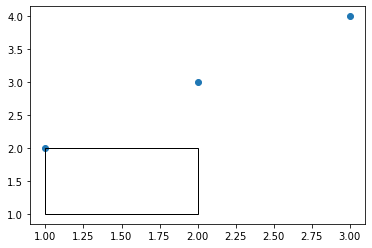

In [5]:
import matplotlib.pyplot as plt

plt.scatter([1,2,3],[2,3,4])
rect = plt.Rectangle((1,1),1,1,fill=False)
ax=plt.gca()
ax.add_patch(rect)
plt.show()

In [2]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.core import from_cuboids
from cs.concept import Concept
import matplotlib.pyplot as plt
import visualization.concept_inspector as ci
import numpy as np
from matplotlib import patches
from sklearn.metrics import average_precision_score

C=0.05


path = "Dataset\\prototypes.xml"
path2 = "Dataset\\exemplars.xml"


def print_database(node,indent=''):
    print(indent,node.tag,end=' ')
    try:
        print(node.attrib['name'],end=' ')
    except KeyError:
        pass
    if len(node):
        print()
        for subelem in node:
            print_database(subelem,indent+"  ")
    else:
        print(node.text)
    
def get_domains(xml_elem):
    domains = xml_elem.find('genericPhysicalDescription')
    if(not(domains)):
        return
    domain_dict={}
    try:
        supercategory = xml_elem.find('family').text
        if supercategory in ['feline','rodent','primate','cetacean']:
            supercategory='mammal'
        elif supercategory in ['crustacean']:
            supercategory = 'arthropod'
        elif supercategory in ['fruit', 'transport', 'furniture', 'book', 'building', 'musical_instrument', 'present', 'architectural_element']:
            supercategory = 'object'
        domain_dict['supercategory']=supercategory
    except AttributeError:
        domain_dict['supercategory']="object"
        
    for domain in domains:
        numerical_domain={}
        for subelem in domain:
            try:
                numerical_domain[subelem.tag]=float(subelem.text)
            except ValueError:
                pass
        if numerical_domain:
            domain_name=domain.tag
            
            if not (domain_name=='size' or domain_name=='location'):
                pass
            elif(domain_name=='hasPart' or domain_name=='partOf'):
                pass
                '''domain_name = domain.get('name')
                domain_dict['n_'+domain_name]={'number_'+domain_name:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}'''
            else:
                domain_dict[domain_name]={key:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}
    return domain_dict

def xml_to_dict(path, exemplars = {}):
    tree = ET.parse(os.path.normpath(path))
    root = tree.getroot()
    for exemplar in root:
        new_concept = get_domains(exemplar)
        if(new_concept):
            exemplars[exemplar.attrib['name']] = new_concept
    return exemplars

def is_consistent(concept):
    for domain in concept:
        if not domain=='supercategory':
            if not(len(concept[domain])==len(space._domains[domain])):
                return False
    return True
                
def dict_to_point(concept_dict, normalize=False):
    point=[concept_dict.get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
    #flatten
    point= [p for dom in point for p in dom]
    if normalize:
        return space._z(point)
    else:
        return point

def normalize_point(point):
    return space._z(point)

'''#Normalize given instance of data, return respective z-transformation, needs initialized space
def normalize_concepts(concepts):
    if not space:
        raise EmptySpaceError from Exception
    maxval=[0 for _ in range(space._n_dim)]
    minval=[0 for _ in range(space._n_dim)]
    for supercategory in space.data.values():
        for example in supercategory.values():
            maxval=[max([maxval[i]]+[example[1][i] if not example[1][i]==float('inf')]) for i in range(space._n_dim)]
            minval=[min([minval[i]]+[example[0][i] if not example[0][i]==float('-inf')]) for i in range(space._n_dim)]

    z=lambda x: [(x[i]-(maxval[i]+minval[i])/2)/maxval[i] for i in range(space._n_dim)]
    
    for supercategory in space.data.values():
        for example in supercategory.values():
            example[1]=list(z(example[1]))
            example[0]=list(z(example[0]))
    if space:
        space._z=z
    return z'''

def point_to_domains(point):
    domains={}
    for dim in range(space._n_dim):
        if not(point[dim]==float('inf') or point[dim]==float('-inf')):
            domains[space._dim_to_dom[str(dim)]]=space._domains[space._dim_to_dom[str(dim)]]
    return domains
    
def concept_into_space(concept, name):
    cuboids=[]
    domains = {}
    for example in ordered_dict[category]:
        if not is_consistent(concepts[example]):
            print(example,' is inconsistent')
            del(concepts[example])
        else:
            subdomains={domain:space._domains[domain] for domain in concepts[example] if not domain == 'supercategory'}
            point=[concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
            point=[p for dom in point for p in dom]
            if normalize:
                point=normalize_point(point)
            cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
            domains.update(subdomains)

    core=from_cuboids(cuboids,domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    space.add_concept(category,concept,next(colors))
    
def concepts_into_space(concepts, domains={}, except_for=None, colors=['b','g','r','c','m','brown','rosybrown','darkslategrey','pink','grey'], superc='animal', normalize=False):
    if except_for:
        for concept in list(concepts.keys()):
            if concepts[concept]['supercategory']==except_for:
                del(concepts[concept])
                
    ordered_dict={}
    for example in concepts:
        if concepts[example]['supercategory'] in ordered_dict:
            ordered_dict[concepts[example]['supercategory']].append(example)
        else:
            ordered_dict[concepts[example]['supercategory']]=[example]
    
    colors=iter(colors)
    concept_colors={}
    if(domains=={}):
        for concept in concepts.values():
            domains.update(concept)
        del(domains['supercategory'])
    #domains = mapping: domain->dimension indices
    domain_mapping = {}
    i=0
    for key in domains:
        domain_mapping[key]=list(range(i,i+len(domains[key])))
        i+=len(domains[key])

    dimension_names = []
    for domain in domains.values():
        dimension_names += [dim for dim in domain.keys()]
    
    if space._n_dim==None:
        space.init(len(dimension_names),domain_mapping,dimension_names)
    else:
        pass
    
    for category in ordered_dict:
        cuboids=[]
        domains = {}
        for example in ordered_dict[category]:
            if not is_consistent(concepts[example]):
                print(example,' is inconsistent')
                del(concepts[example])
            else:
                subdomains={domain:space._domains[domain] for domain in concepts[example] if not domain == 'supercategory'}
                point=[concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
                point=[p for dom in point for p in dom]
                if normalize:
                    point=normalize_point(point)
                cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
                domains.update(subdomains)

        core=from_cuboids(cuboids,domains)
        weights=Weights(space._def_dom_weights,space._def_dim_weights)
        concept=Concept(core, 1.0, C, weights)
        space.add_concept(category,concept,next(colors))
        
    if not superc==None:
        animal_concept=[]
        for concept in space._concepts.values():
            animal_concept+=concept._core._cuboids
        core=from_cuboids(animal_concept,space._domains)
        weights=Weights(space._def_dom_weights,space._def_dim_weights)
        concept=Concept(core, 1.0, C, weights)
        space.add_concept(superc,concept,next(colors))
    
    return concepts
        
"""    for example in concepts:
        if concepts[example]['supercategory'] in ['mammal','reptile','bird','amphibian','insect']:
            consistent = True
            domains = {}
            for key in concepts[example]:
                if(not(key=='supercategory')):
                    domains[key]=space._domains[key]

            '''dimension_names = []

            for concept_domain in concepts[example].values():
                dimension_names += [dim for dim in domain.keys()]'''

            dimension_values=[]
            for domain in space._domains.keys():
                dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                                     ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
                if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
                    #print(domain+' in '+example+' is inconsistent')
                    consistent=False
                    break
                if(not(consistent)):
                    print('bah')


            if(consistent):
                p_min=[value for domain in dimension_values for value in domain[0]]
                p_max=[value for domain in dimension_values for value in domain[1]]

                #try:
                c_example = Cuboid(p_min, p_max, domains)
                s_example = Core([c_example], domains)
                w_example = Weights(space._def_dom_weights,space._def_dim_weights)
                concept = Concept(s_example, 1.0, C, w_example)

                supercategory = concepts[example]['supercategory']
                if(supercategory in space._concepts):
                    space.add_concept(supercategory, space._concepts[supercategory].union_with(concept), concept_colors[supercategory])
                else:
                    concept_colors.update({supercategory:next(colors)})
                    space.add_concept(supercategory, concept, concept_colors[supercategory])"""
                #print('added ', example)
                #print(concepts[example]['supercategory'])
        #except Exception:
        #    print(example,'is inconsistent')

def point_to_concept(point, name):
    domains = domains_from_point(point)
    p_min=[value if not value==float('inf') else float('-inf') for value in point]
    c_example = Cuboid(p_min, point, domains)
    s_example = Core([c_example], domains)
    w_example = Weights(space._def_dom_weights,space._def_dim_weights)
    concept = Concept(s_example, 1.0, C, w_example)
    space.add_concept(name, concept)
    return concept

def normalize_space():
    maxval=[0 for _ in range(space._n_dim)]
    minval=[0 for _ in range(space._n_dim)]
    for concept in space._concepts.values():
        maxval=[max([maxval[i]]+[cub._p_max[i] for cub in concept._core._cuboids if not cub._p_max[i]==float('inf')]) for i in range(space._n_dim)]
        minval=[min([minval[i]]+[cub._p_min[i] for cub in concept._core._cuboids if not cub._p_min[i]==float('-inf')]) for i in range(space._n_dim)]
    
    z=lambda x: [(x[i]-(maxval[i]+minval[i])/2)/maxval[i] for i in range(space._n_dim)]
    
    for concept in space._concepts.values():
        for cuboid in concept._core._cuboids:
            cuboid._p_max=list(z(cuboid._p_max))
            cuboid._p_min=list(z(cuboid._p_min))
    space._z=z

#learns/assumes supercategory of point and put it into space
def one_shot(point, supercategory='none', mechanism=None, sibblings=None, name="newlearned"):
    #todo find lowest concept

    if supercategory=='none':
        superkey = max(space._concepts,key= lambda candidate:space._concepts[candidate].membership_of(point))
    else:
        superkey = supercategory
    
    if(mechanism==None):
        #average sizes method
        supercategory = space._concepts[superkey]
        avg = lambda values: sum(values)/len(values) if len(values) else float('inf')
        #print([[cuboid._p_max[dim]-cuboid._p_min[dim] for cuboid in supercategory._core._cuboids if not cuboid._p_max[dim]==float('inf')]for dim in range(space._n_dim)])
        avg_sizes=[avg([cuboid._p_max[dim]-cuboid._p_min[dim] for cuboid in supercategory._core._cuboids if not cuboid._p_max[dim]==float('inf')]) for dim in range(space._n_dim)]
        print('supercategory is:')
        print(superkey)
        print(avg_sizes)
        print()
        p_min = [point[i]-1/2*avg_sizes[i] for i in range(space._n_dim)]
        p_max = [point[i]+1/2*avg_sizes[i] for i in range(space._n_dim)]
        cuboid=Cuboid(p_min, p_max, space._domains)#not working in bigger examples
        core=Core([cuboid],space._domains)
        weights=Weights(space._def_dom_weights,space._def_dim_weights)
        concept=Concept(core, 1.0, C, weights)
        return concept
    else:
        concept=mechanism(point, superkey, sibblings)
        space.add_concept(name,concept,color='y')
        return concept

def domains_from_point(point):
    domains={}
    for domain in space._domains:
        if all(not point[dim]==float('inf') for dim in space._domains[domain]):
            domains[domain]=space._domains[domain]
    return domains
    
    
def get_sibblings(supercat):
    sibblings=[]
    for concept in space._concepts:
        if not concept==supercat:
            print('check:',concept)
            if space._concepts[concept].subset_of(space._concepts[supercat])==1.0:
                sibblings.append(concept)
    return sibblings
        
def two_cuboids(point, supercategory, sibblings=None):
    #fig,ax = plt.subplots(1)
    
    n_dims=len(point)
    if sibblings==None:
        sibblings=get_sibblings(supercategory)
        
    variances=[]
    correlations=[]
    stds=[]#np.std(centers)
    avg = np.average#lambda values: sum(values)/len(values)
    for sibbling in sibblings:
        centers = np.array([[p_max-p_min for p_max,p_min in zip(cuboid._p_max, cuboid._p_min)] for cuboid in space._concepts[sibbling]._core._cuboids]).T
        means=[]
        for dimension in range(len(centers)):
            means.append(avg([value for value in centers[dimension] if not value==float('inf')]))
            for value in range(len(centers[dimension])):
                if centers[dimension,value]==float('inf'):
                    centers[dimension,value]=means[-1]
        if(len(centers.T)==1):
            centers=np.array([[x[0],x[0]] for x in centers])
        stds.append(np.std(centers,1))
        #covmat = np.cov(centers)
        corr=np.corrcoef(centers)
        #plt.scatter(centers[0],centers[1])
        #variances.append(covmat)
        if not np.isnan(corr[0,0]):
            correlations.append(corr)
            
    meanstds=np.zeros(n_dims)
    meancorrelations=np.zeros([n_dims, n_dims])
    for i in range(n_dims):
        meanstds[i] = avg([stds[sib][i] for sib in range(len(stds))])
        #meanvariances[i] = avg([(variance_of_sibbling[i,i])**(1/2) for variance_of_sibbling in variances])
        for j in range(n_dims):
            meancorrelations[i,j]= avg([correlations_of_sibbling[i,j] for correlations_of_sibbling in correlations])
    #print(meanvariances)
    #print(meanstds)
    #print([avg([stds[sib][dim] for sib in range(len(stds))]) for dim in range(n_dims)])
    #print(meancorrelations)
    maindim=0
    cub1=np.zeros(n_dims)
    cub2=np.zeros(n_dims)
    cub1[maindim]=point[maindim]-meanstds[maindim]
    cub2[maindim]=point[maindim]+meanstds[maindim]
    
    for dim in range(n_dims):
        if not dim==maindim:
            cub1[dim]=point[dim]-meancorrelations[maindim,dim]*meanstds[maindim]
            cub2[dim]=point[dim]+meancorrelations[maindim,dim]*meanstds[maindim]
        
    c1_p_min=[2*cub1[dim]-point[dim] if cub1[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c1_p_max=[2*cub1[dim]-point[dim] if cub1[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    
    c2_p_min=[2*cub2[dim]-point[dim] if cub2[dim] < point[dim] else float('-inf') if point[dim]==float('inf') else point[dim] for dim in range(n_dims)]
    c2_p_max=[2*cub2[dim]-point[dim] if cub2[dim] > point[dim] else point[dim] for dim in range(n_dims)]
    

    '''rect=patches.Rectangle(c1_p_min[0:2],c1_p_max[0]-c1_p_min[0],c1_p_max[1]-c1_p_min[1])
    ax.add_patch(rect)
    rect=patches.Rectangle(c2_p_min[0:2],c2_p_max[0]-c2_p_min[0],c2_p_max[1]-c2_p_min[1])
    ax.add_patch(rect)
    print(rect.get_xy())
    plt.show()'''
    
    domains = domains_from_point(c1_p_max)
    core=Core([Cuboid(c1_p_min, c1_p_max, domains),Cuboid(c2_p_min,c2_p_max,domains)],domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, C, weights)
    return concept
    
    
def average_precision(concept, negatives, positives, threshold=0.5, color='r', figure=None):

    y_true=np.concatenate((np.ones(len(positives)),np.zeros(len(negatives))))
    y_scores=np.zeros(len(y_true))
    for i in range(len(y_scores)):
        if i < len(positives):
            y_scores[i]=concept.membership_of(positives[i])
        else:
            y_scores[i]=concept.membership_of(negatives[i-len(positives)])
    #precision(concept, negatives, positives, threshold)
    sorted_truths=[x for _,x in sorted(zip(y_scores,y_true),reverse=True)]
    #print(sorted_truths)
    recalls=[sum(sorted_truths[:i+1])/(sum(sorted_truths[:i+1])+sum(sorted_truths[i:])) for i in range(len(y_true))]
    precisions=[sum(sorted_truths[:i+1])/(i+1) for i in range(len(y_true))]
    '''print(sorted_truths)
    print(recalls)
    print(precisions)'''
    #plt.subplots(figsize=(10, 10))
    if figure=='part':
        plt.scatter(recalls, precisions, color = color)#[(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
    elif figure=='developement':
        plt.scatter(recalls, precisions, color = [(0.5,x,x) for x in [(len(recalls)-i)/len(recalls) for i in range(len(recalls))]])
        plt.show()
    #plt.figure(figsize=(10,20))
    '''plt.xlabel('Recall')
    plt.ylabel('Precision')'''
    #plt.show()
    return average_precision_score(y_true, y_scores)

def precision(concept, negatives, positives, threshold=0.5):
    tp=0
    fp=0
    tn=0
    fn=0
    print('tresh:',threshold)
    for datum in negatives:
        if concept.membership_of(datum)>=threshold:
            fp+=1
        else:
            tn+=1
    for datum in positives:
        if concept.membership_of(datum)>=threshold:
            tp+=1
        else:
            #print(datum)
            fn+=1
    try:
        print('Precision: ',tp/(tp+fp))
    except ZeroDivisionError:
        pass
    print('tp:',tp,'fp:',fp)
    try:
        print('Recall: ',tp/(tp+fn))
    except ZeroDivisionError:
        pass
    print('tp:',tp,'fn:',fn)
''

''

bat  is inconsistent
little_brown_bat  is inconsistent
Sea_Turtle_Dermochelys_Choriacea  is inconsistent
trachemys_turtle  is inconsistent
salmon  is inconsistent
Sockeye_Salmon  is inconsistent
Golden_Trout  is inconsistent
spider  is inconsistent
thin_leg_spider  is inconsistent
owl  is inconsistent
Swan
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.23538631721435918
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

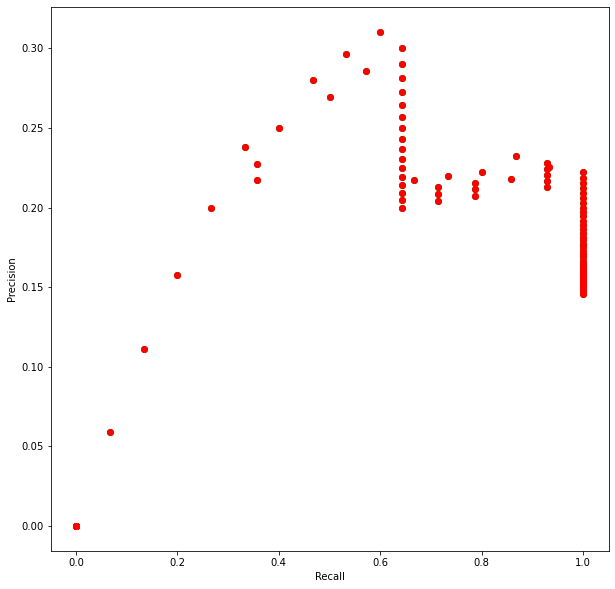

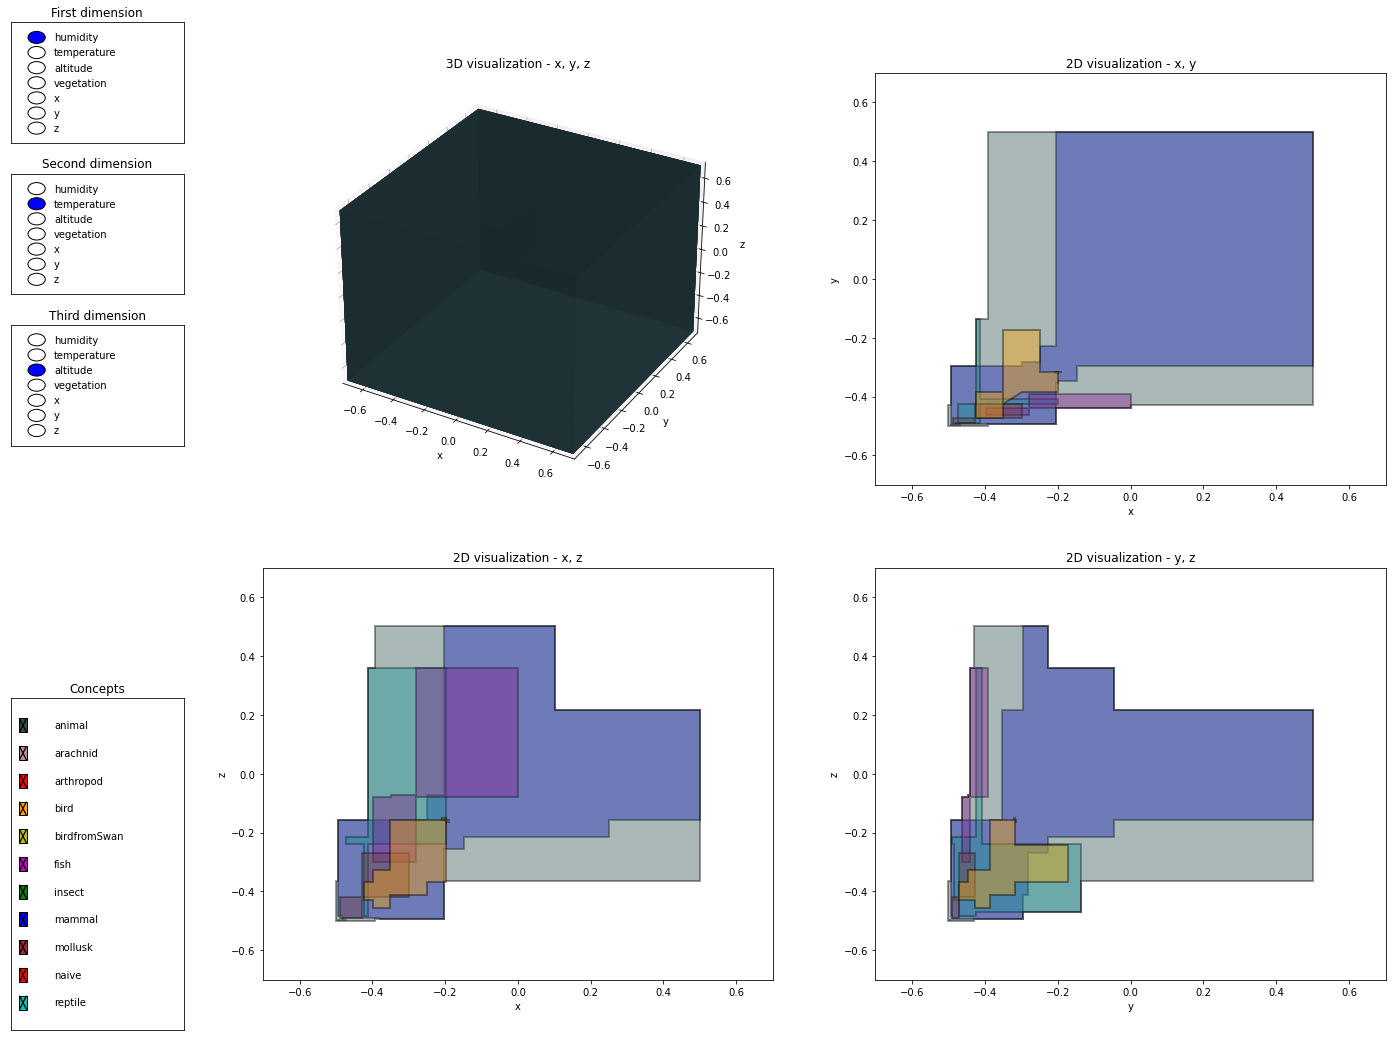

''

In [4]:
import random
def random_example(exampledict):
    return random.choice([animal for animal in exampledict.keys()])

#parameters
example='Swan'

#read concepts from prototypes and exemplars
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

#dict domains lists all domains shich later will be in cs
domains = {}
for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])



#remove objects for now (into_space still only animals)
to_del=[]
for concept in concepts:
    if concepts[concept]['supercategory']=='object' or concepts[concept]['supercategory']=='amphibian' or concept=='whale':
        to_del.append(concept)
for conc in to_del:
    del(concepts[conc])

#random_example(concepts)
    
#remove the testexample from traindata
#del(concepts[example])
target=concepts[example]['supercategory']
#mammal={key:concepts[key] for key in concepts if concepts[key]['supercategory']=='mammal'}


#testset = everythink that makes up superategory of example except for example
trainset={}
testset={}
for concept in concepts:
    if not concepts[concept]['supercategory']==target:
        trainset[concept]=concepts[concept]
    elif not concept==example:
        testset[concept]=concepts[concept]
        
        
#the supercategory of to_learn will not be put into space
trainset = concepts_into_space(trainset)
normalize_space()

#cs is there, so we can translate the data into points
negatives=[dict_to_point(concept) for concept in trainset.values()]

#get point from dict of example
dimension_values=[]
consistent = True
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break
    
p_max=[value for domain in dimension_values for value in domain[1]]

'''domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]'''


#save time
sibblings = [family for family in ['mammal', 'insect', 'arthropod', 'reptile', 'fish', 'arachnid', 'bird'] if not family==target]
#sibblings=None
#oneshot
p_max=normalize_point(p_max)
try:
    sibblings
except NameError:
    sibblings=get_sibblings('animal')
learnt_category=one_shot(p_max, 'animal',two_cuboids,sibblings=sibblings,name=target+'from'+example)



target_dict={}

testset=concepts_into_space(testset, superc=None, colors=['orange'], normalize=True)
positives=[dict_to_point(concept) for concept in testset.values()]

naive_category=point_to_concept(p_max,'naive')
#space.add(naive_concept)
print(example)
#print(len(testset))
threshold=0.2
plt.subplots(figsize=(10, 10))

'''for negative in negatives:
    print(len(negative))
    print(negative)
for positive in positives:
    print(len(positive))
    print(positive)'''

print(average_precision(learnt_category, negatives, positives, threshold, color='g'))
print(average_precision(naive_category, negatives, positives, threshold))
#ci.init()
#naive_category.membership_of([200.0, 550.0, 250.0])
#print('learnt:',learnt_category)
#print('naive:',naive_category)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show
ci.init(dims=[4,5,6])
''

In [5]:
'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'=='[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'

True

In [ ]:
for concept in space._concepts.values():
    print(concept)

In [49]:
a=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b=[0.09542066255961211, 0.08665094692877454, 0.04122357110868853, 0.09379832511134238, 0.04122357110868853, 0.04165293814897211, 0.20032402215100903, 1.0, 0.10528594664234403, 0.04165293814897211, 0.04165293814897211, 0.03406475258762248, 0.04165293814897211, 0.04122357110868853, 0.1251475871119652, 0.0, 0.011090982014362625, 0.01533101317225377, 0.0016195455709199422, 0.0188473615460499, 0.005683180632713135, 0.028203031271982367, 1.2252480455743555e-06, 0.003577950719990046, 0.06543430228338303, 0.2357414886376605, 0.12518869192408613, 0.001378462296061045, 0.05131892692730364, 0.006031244734147609, 0.01639768592048284, 0.0297625931554308, 0.12518869192408613, 0.12205405363335159, 0.07132569057350516, 0.08750889840833628, 0.1451860223368463, 0.016726759536327157, 0.010038862250100606, 0.1134435482255714, 0.12518869192408613, 0.12205405363335159, 0.023064190570476848, 0.017678265704436435, 0.1357165685619127, 0.016499162114146513, 0.25793181751598837, 0.015306849885686735, 0.07171749875878075, 0.17471103084746137, 0.015679224890244668, 0.01533101317225377, 0.014288368939026299, 0.1031656290731522, 0.0, 0.4483494415756112, 0.006031244734147609, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06517420164257998, 0.12205405363335159, 0.12205405363335159, 0.07132569057350516, 0.07132569057350516, 0.08750889840833628, 0.08750889840833628, 0.062194661286017305, 0.09696209937961606, 0.1451860223368463, 0.013446419551227147, 0.013446419551227147, 0.1134435482255714, 0.1134435482255714, 0.1134435482255714, 0.13926253025694413, 0.12376558071722764, 0.08919416199011321, 0.04085992915680036, 0.09081526298518361, 0.05131892692730364, 0.288325374012604, 0.019070871602740232, 0.01453220954880814, 0.17471103084746137, 0.17471103084746137, 0.11799256956681889, 0.1855843380986964, 0.1666918124883832, 0.011090982014362625, 0.011090982014362625, 0.01533101317225377, 0.1031656290731522, 0.1031656290731522, 0.4702271062490033, 0.12205405363335159, 0.0, 0.02807638510728198, 0.017536566130392006, 0.01765128415367437, 0.014288368939026299, 0.014288368939026299, 0.017869277418336788, 0.022264474551520915]
#b=[x*10 for x in b]
print(min(b[:15]))
print(max(b[15:]))
average_precision_score(a, b)

0.03406475258762248
0.4702271062490033


0.2484466916809871

In [3]:

#read concepts from prototypes and exemplars
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

#dict domains lists all domains shich later will be in cs
domains = {}
for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])



#remove objects for now (into_space still only animals)
to_del=[]
for concept in concepts:
    if concepts[concept]['supercategory']=='object' or concepts[concept]['supercategory']=='amphibian' or concept=='whale':
        to_del.append(concept)
for conc in to_del:
    del(concepts[conc])


#mammal={key:concepts[key] for key in concepts if concepts[key]['supercategory']=='mammal'}

concepts=concepts_into_space(concepts)
remember={}
examples=concepts.keys()
#testset = everythink that makes up superategory of example except for example
for example in examples:
    target=concepts[example]['supercategory']
    trainset={}
    testset={}
    for concept in concepts:
        if not concepts[concept]['supercategory']==target:
            trainset[concept]=concepts[concept]
        elif not concept==example:
            testset[concept]=concepts[concept]


    #the supercategory of to_learn will not be put into space
    concepts_into_space(trainset)
    normalize_space()

    #cs is there, so we can translate the data into points
    negatives=[dict_to_point(concept, normalize=True) for concept in list(trainset.values())]
    positives=[dict_to_point(concept, normalize=True) for concept in testset.values()]

    #get point from dict of example
    dimension_values=[]
    consistent = True
    for domain in space._domains.keys():
        dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                             ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
        if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
            print(domain+' in '+example+' is inconsistent')
            consistent=False
            break

    p_max=[value for domain in dimension_values for value in domain[1]]

    '''domains = {}
    for key in concepts[example]:
        if(not(key=='supercategory')):
            domains[key]=space._domains[key]'''


    #save time
    sibblings = [family for family in ['mammal', 'insect', 'arthropod', 'reptile', 'fish', 'arachnid', 'bird'] if not family==target] 
    #sibblings=['mammal', 'insect', 'arthropod', 'reptile', 'fish', 'arachnid']
    #sibblings=None
    #oneshot
    try:
        sibblings
    except NameError:
        sibblings=get_sibblings('animal')
        
    if not all([value==float('inf') for value in p_max]):
        p_max=normalize_point(p_max)
        learnt_category=one_shot(p_max, 'animal',two_cuboids,sibblings=sibblings,name=target+'from'+example)



        target_dict={}

        concepts_into_space(testset, superc=None, colors=['orange'], normalize=True)
        naive_category=point_to_concept(p_max,'naive')

        ap_learnt=average_precision(learnt_category, negatives.copy(), positives.copy())
        ap_naive=average_precision(naive_category, negatives, positives)
        #print(example,':\n',ap_learnt-ap_naive,'\n')
        if not np.isnan(ap_learnt):
            remember[example]=[ap_learnt,ap_naive]
    else:
        #print(example,'is empty')
        pass
    
    print(max([val for concept in space._concepts.values() for cuboid in concept._core._cuboids for val in cuboid._p_max if not val==float('inf')]))
    space._n_dim=None

bat  is inconsistent
little_brown_bat  is inconsistent
owl  is inconsistent
Sea_Turtle_Dermochelys_Choriacea  is inconsistent
trachemys_turtle  is inconsistent
salmon  is inconsistent
Sockeye_Salmon  is inconsistent
Golden_Trout  is inconsistent
spider  is inconsistent
thin_leg_spider  is inconsistent


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7
2.25
1.5


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1.5
0.7
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\ipykernel_launcher.py:421: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\PC\anaconda3\envs\CSpy3\lib\sit

1.5
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

0.7
2.25
2.2607022840704376
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


2.25
1.5
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

0.7
2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


2.25
1.5
2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


2.25
1.5
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7
2.25
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

0.7
1.5
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7
2.25
1.5


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1.5
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


0.7
0.7
0.7
0.7
0.8333333333333334
0.8333333333333334
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7
0.7
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

2.25
2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

2.25
2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

0.7
0.7
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1.519301451440969
1.5
1.5


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1.5
2.25
2.25
0.7
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\ipykernel_launcher.py:421: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\ipykernel_launcher.py:421: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\fun

0.7
2.25
2.25
2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

1.5
0.7
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anac

2.25
2.25
2.25
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


2.25
1.5
2.25


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


0.7
0.7
0.7


C:\Users\PC\anaconda3\envs\CSpy3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [13]:
print(max([val for concept in space._concepts.values() for cuboid in concept._core._cuboids for val in cuboid._p_max if not val==float('inf')]))

0.7


In [14]:
'''for concept in space._concepts:
    print(concept)'''
for animal in space._concepts:
    if any([x>5 for cuboid in space._concepts[animal]._core._cuboids for x in cuboid._p_max if not x==float('inf')]):
        print(animal)

core: {[0.020293156023392087, 0.2724257406436114, -0.20604588863077433, 0.48412473959727753, -0.425, -0.4727272727272727, -0.48540936651548616]-[0.1, 0.3, -0.2, 0.5, -0.4188324395448408, -0.46267792618725084, -0.4828571428571429], [0.1, 0.3, -0.2, 0.5, -0.4311675604551592, -0.4827766192672946, -0.4828571428571429]-[0.17970684397660794, 0.32757425935638856, -0.1939541113692257, 0.5158752604027226, -0.425, -0.4727272727272727, -0.4803049191987996]}
mu: 1.0
c: 0.05
weights: <{'location': 1.0, 'size': 1.0},{'location': {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 'size': {4: 0.3333333333333333, 5: 0.3333333333333333, 6: 0.3333333333333333}}>


In [15]:
remember
ap=[x[0] for x in remember.values()]
diff_ap=[x[0]-x[1] for x in remember.values()]
ap=diff_ap

In [16]:
print(len(remember))

90


In [17]:
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

0.10798319327731087
-0.04166666666666663
0.002734547651357885


In [11]:
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

0.9285714285714286
0.03292540792540792
0.52830641299195


In [36]:
#5
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

0.41666666666666674
-0.022222222222222365
0.006338469255221928


In [32]:
#15
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

0.33333333333333326
-0.33333333333333326
-0.008670218468672913


In [28]:
#all 3dims
print(max(ap))
print(min(ap))
print(sum(ap)/len(ap))

0.18956582633053226
-0.2124999999999999
-0.010353666998463653


In [7]:
len(ap)

90

In [8]:
concept=space._concepts['reptile']
supercat='animal'
space._concepts[concept].subset_of(space._concepts[supercat])

TypeError: unhashable type: 'Concept'

In [3]:
concepts

{'Rhinoceros': {'supercategory': 'mammal'},
 'bear': {'supercategory': 'mammal',
  'size': {'x': 150.0, 'y': 250.0, 'z': 100.0}},
 'Swan': {'supercategory': 'bird',
  'size': {'x': 60.0, 'y': 100.0, 'z': 120.0}},
 'Robin': {'supercategory': 'bird', 'size': {'x': 20.0, 'y': 30.0, 'z': 60.0}},
 'butterfly': {'supercategory': 'insect',
  'size': {'x': 6.0, 'y': 3.0, 'z': 0.5}},
 'camel': {'supercategory': 'mammal',
  'size': {'x': 90.0, 'y': 250.0, 'z': 300.0}},
 'chicken': {'supercategory': 'bird',
  'size': {'x': 25.0, 'y': 40.0, 'z': 45.0}},
 'crab': {'supercategory': 'arthropod',
  'size': {'x': 15.0, 'y': 3.0, 'z': 8.0}},
 'crocodile': {'supercategory': 'reptile',
  'size': {'x': 60.0, 'y': 50.0, 'z': 300.0}},
 'dolphin': {'supercategory': 'mammal',
  'size': {'x': 60.0, 'y': 80.0, 'z': 250.0}},
 'giraffe': {'supercategory': 'mammal',
  'size': {'x': 200.0, 'y': 550.0, 'z': 250.0}},
 'horse': {'supercategory': 'mammal',
  'size': {'x': 100.0, 'y': 200.0, 'z': 300.0}},
 'koala': {'sup

In [5]:
bool(None)

False

putting bird into space
putting insect into space
putting arthropod into space
putting reptile into space
putting amphibian into space
putting fish into space
putting mollusk into space
putting arachnid into space
bear:
[150.0, 250.0, 100.0]
supercategory is:
bird
[17.5, 49.166666666666664, 33.333333333333336]

supercategory is:
animal
[25.997959183673466, 57.63186813186813, 66.47755102040817]

supercategory is:
bear from animal
[25.99795918367346, 57.631868131868146, 66.47755102040816]

supercategory is:
animal
[25.997959183673466, 57.63186813186813, 66.47755102040817]

putting mammal into space
amphibian:
core: {[10.0, 15.0, 5.0]-[10.0, 20.0, 10.0], [10.0, 10.0, 10.0]-[10.0, 15.0, 15.0]}
mu: 1.0
c: 0.5
weights: <{'size': 1.0},{'size': {0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}}>
axes_ranges:
 [(-119.52000000000001, 719.9200000000001), (-108.80000000000001, 659.8), (-2399.52, 14399.92)]
beep
beep


IndexError: list assignment index out of range

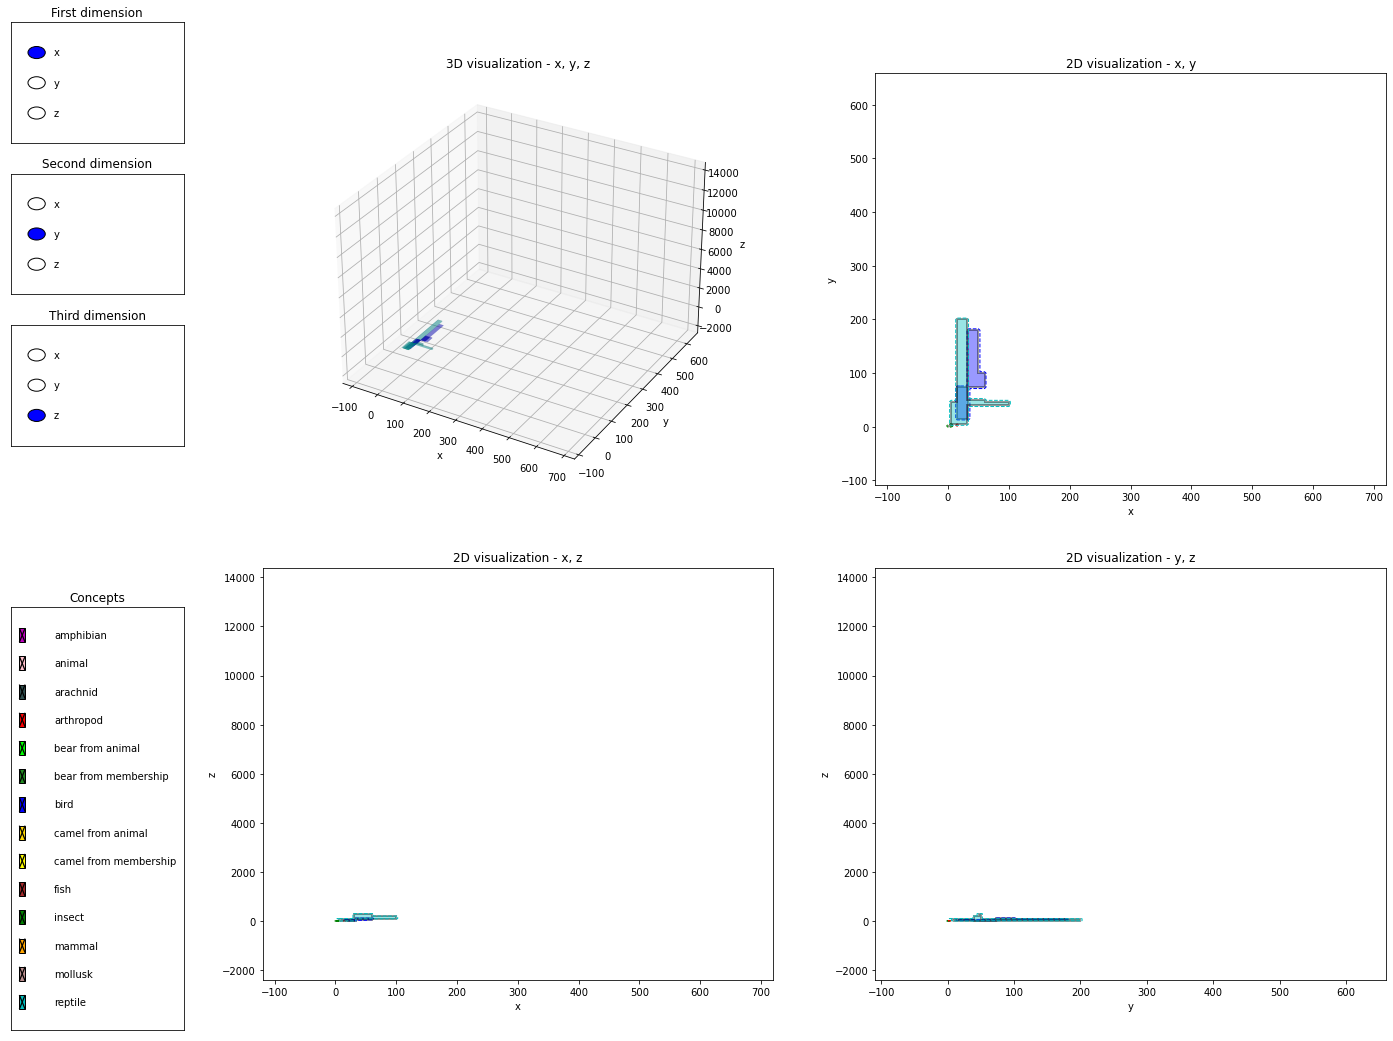

In [2]:
#%matplotlib widget
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

#print(concepts)

domains = {}

for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])


example='bear'
        
to_learn={example:concepts[example]}
del(concepts[example])
mammal={key:concepts[key] for key in concepts if concepts[key]['supercategory']=='mammal'}

to_del=[]
for concept in concepts:
    if concepts[concept]['supercategory']=='object':# or concepts[concept]['supercategory']=='amphibian':
        to_del.append(concept)
for conc in to_del:
    del(concepts[conc])
        
concepts_into_space(concepts.copy(), except_for=to_learn[example]['supercategory'])

#print(space._concepts['reptile'])

dimension_values=[]
concepts=to_learn
consistent = True
#print(bear)
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break

domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]

'''print(dimension_values)
print(domains)'''

'''if(consistent):
        p_min=[value for domain in dimension_values for value in domain[0]]
        p_max=[value for domain in dimension_values for value in domain[1]]

        #try:
        c_example = Cuboid(p_min, p_max, domains)
        s_example = Core([c_example], domains)
        w_example = Weights(space._def_dom_weights,space._def_dim_weights)
        bear = Concept(s_example, 1.0, 0.5, w_example)
        space.add_concept(example, bear, 'yellow')'''

'''for concept in space._concepts:'''
#print(concept)
p_max=[value for domain in dimension_values for value in domain[1]]
print('bear:')
print(p_max)

space.add_concept(example+' from membership',one_shot(p_max),'forestgreen')
space.add_concept(example+' from animal',one_shot(p_max,supercategory='animal'),'lime')

example='camel'

to_learn={example:mammal[example]}
dimension_values=[]
concepts=to_learn
consistent = True
#print(bear)
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break

domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]
        
p_max=[value for domain in dimension_values for value in domain[1]]        
space.add_concept(example+' from membership',one_shot(p_max),'yellow')
space.add_concept(example+' from animal',one_shot(p_max,supercategory='animal'),'gold')

concepts=mammal
ordered_dict={}
for example in concepts:
    if concepts[example]['supercategory'] in ordered_dict:
        ordered_dict[concepts[example]['supercategory']].append(example)
    else:
        ordered_dict[concepts[example]['supercategory']]=[example]
for category in ordered_dict:
    print('putting',category,'into space')
    cuboids=[]
    domains = {}
    for example in ordered_dict[category]:
        if not is_consistent(concepts[example]):
            print(example,' is inconsistent')
        else:
            subdomains={domain:space._domains[domain] for domain in concepts[example] if not domain == 'supercategory'}
            point=[concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values() for domain in space._domains]
            point=[p for dom in point for p in dom]
            #print(example)
            #print('point: ',point)
            cuboids.append(Cuboid([dim if not dim==float('inf') else -dim for dim in point], point, subdomains))
            domains.update(subdomains)
            #print(cuboids[-1]._p_max)
    #for cuboid in cuboids:
        #print('cuboid:',cuboid)
    core=from_cuboids(cuboids,domains)
    weights=Weights(space._def_dom_weights,space._def_dim_weights)
    concept=Concept(core, 1.0, 0.5, weights)
    space.add_concept(category,concept,'orange')
    
    
        #print(space._concepts[concept].membership_of([p if not p==float('-inf') else 0 for p in p_min]))
        #print(space._concepts[concept].membership_of(p_max))
            #print(bear.subset_of(space._concepts[concept]))
print('amphibian:')
print(space._concepts['amphibian'])
ci.init()

In [5]:
axis_ranges=[(-119.52000000000001, 719.9200000000001), (-108.80000000000001, 659.8), (-2399.52, 14399.92)]


cuboid=([-119.53000000000002, -108.81000000000002, -2399.53], [719.9300000000001, 659.81, 14399.93])
d1,d2=0,1
print(any([not (cuboid[0][i]==axis_ranges[i][0] and cuboid[1][i]==axis_ranges[i][1]) for i in [d1,d2]]))

True


In [13]:
[1,2,3]+[4,5,6]

[1, 2, 3, 4, 5, 6]

In [4]:
x={a:1 for a in {'1':10,'2':20,'3':30} if not a==3}
concepts={'example':{'supercategory':1,'locomotion':2,'size':3}}
example='example'
subdomains={domain:1 for domain in concepts[example] if not domain == 'supercategory'}
subdomains

{'locomotion': 1, 'size': 1}

In [3]:
min([1,2,None,3])

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [3]:
bird
c1:  4.0  -  4.0  c2:  6.0  -  8.0 

c1:  10.0  -  10.0  c2:  16.875  -  25.66801525297619 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  150.0  -  150.0  c2:  29.981498794987566  -  60.0 

c1:  250.0  -  250.0  c2:  55.51736111111111  -  100.0 

c1:  100.0  -  100.0  c2:  51.063169963987825  -  120.0 

c1:  30.0  -  30.0  c2:  42.45482653423327  -  100.0 

c1:  10.0  -  10.0  c2:  0.0  -  14.333333333333334 

c1:  40.0  -  40.0  c2:  0.0  -  23.333333333333332 

[  5.          13.4375     105.         175.         100.
  36.22741327  10.          31.66666667]
Singular matrix C in LSQ subproblem
0.0

bla
blu


In [3]:
a=float('inf')-float('inf')
a

nan

In [14]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {"color":[0], "shape":[1,2]}
dimension_names = ["hue", "round", 'something']
space.init(3, domains, dimension_names)



# standard weights for the dimensions within each domain
w_dim = {"shape":{1:1,2:1}}

# define pear concept
c_pear = Cuboid([float('-inf'),0.0, 0.0], [float('inf'),4.0, 10.0], {"shape":[1,2]})
s_pear = Core([c_pear], domains)
w_pear = Weights({"shape":0.8}, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')

#del(domains['taste'])
w_dim.update({"color":{0:1}})

# define orange concept
c_orange = Cuboid([0.0,0.0,0.0], [5.0,5.0,10.0], domains)
s_orange = Core([c_orange,c_pear], domains)
w_orange = Weights({"color":1.2, "shape":0.8}, w_dim)
orange = Concept(s_orange, 1.0, 24.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(pear.membership_of([1,1,12]))
print(orange.membership_of([1,1,12]))

#ci.init()

[inf, 1, 10.0] 
zu
[1, 1, 12] 
with
<{'shape': 1.0},{'shape': {1: 0.5, 2: 0.5}}> 

distance:  1.4142135623730951 

1.8178434809396932e-15
[1, 1, 10.0] 
zu
[1, 1, 12] 
with
<{'color': 1.2, 'shape': 0.8},{'shape': {1: 0.5, 2: 0.5}, 'color': {0: 1.0}}> 

distance:  1.1313708498984762 

[inf, 1, 10.0] 
zu
[1, 1, 12] 
with
<{'shape': 1.0},{'shape': {1: 0.5, 2: 0.5}, 'color': {0: 1.0}}> 

distance:  1.4142135623730951 

1.6130401952059783e-12


In [3]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {"locomotion": [0], "bla": [1]}
dimension_names = ["movement", "speed"]
space.init(2, domains, dimension_names)

inf = float('inf')

# standard weights for the dimensions within each domain
w_dim = {"locomotion":{0:1}, "bla":{1:1}}


# define pear concept
c_pear = Cuboid([0.4, 0.1], [0.5, 0.11], domains)
s_pear = Core([c_pear], domains)
w_pear = Weights({"locomotion": 1.0, "bla": 1.0}, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')


# define orange concept
c_orange = Cuboid([0.6, 4.0], [0.8, 20.0], domains)
s_orange = Core([c_orange], domains)
w_orange = Weights({'locomotion': 1.0, 'bla': 1.0}, w_dim)
orange = Concept(s_orange, 1.0, 24.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

#ci.init()

Singular matrix C in LSQ subproblem


Exception: Optimizer failed!

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {'locomotion': [0, 1], 'location': [2, 3, 4, 5], 'feeding': [6, 7], 'size': [8, 9, 10], 'color': [11, 12, 13]}
dimension_names = ['movement', 'speed', 'humidity', 'temperature', 'altitude', 'vegetation', 'foodType', 'foodQuantity', 'x', 'y', 'z', 'l', 'a', 'b']
space.init(14, domains, dimension_names)

inf = float('inf')

# standard weights for the dimensions within each domain
w_dim = space._def_dim_weights
w_dom = space._def_dom_weights


domainsp=domains.copy()
del(domainsp['location'])
del(domainsp['feeding'])
# define pear concept
c_pear = Cuboid([4.0, 10.0, -inf, -inf, -inf, -inf, -inf, -inf, 150.0, 250.0, 100.0, 30.0, 10.0, 40.0], [4.0, 10.0, inf, inf, inf, inf, inf, inf, 150.0, 250.0, 100.0, 30.0, 10.0, 40.0], domainsp)
s_pear = Core([c_pear], domainsp)
w_pear = Weights(w_dom, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')


# define orange concept
c_orange = Cuboid([6.0, 16.875, -inf, -inf, -inf, -inf, -inf, -inf, 29.981498794987566, 55.51736111111111, 51.063169963987825, 42.45482653423327, 0.0, 0.0], [8.0, 25.66801525297619, inf, inf, inf, inf, inf, inf, 60.0, 100.0, 120.0, 100.0, 14.333333333333334, 23.333333333333332], domainsp)
s_orange = Core([c_orange], domainsp)
w_orange = Weights(w_dom, w_dim)
orange = Concept(s_orange, 1.0, 30.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

ci.init()